In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab

from matplotlib import rc
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist
from scipy.special import expit
from scipy.stats import bernoulli
from numpy.polynomial.polynomial import polyval

from scipy.optimize import minimize
from scipy.stats import norm, laplace

rc('font', **{'family': 'serif', 'serif': ['Modern Computer']})
rc('text', usetex=True)

%matplotlib inline

## Data Generation

In [2]:
# set the random seed
random.seed(0)

In [3]:
# generate data from the marginal distributions P(X_0) and P(X_1)
ns = 200
d  = 5
X0 = np.random.randn(ns,d)
X1 = np.random.laplace(0,0.1,size=(ns,d))

In [4]:
# generate Y_0 and Y_1 from the conditional models
b = 0.5
beta_vec  = np.array([0.1,0.2,0.3,0.4,0.5])
Y0 = np.dot(beta_vec,X0.T) + 0.1*np.random.randn(X0.shape[0])      # potential outcome Y_0
Y1 = np.dot(beta_vec,X1.T) + b + 0.1*np.random.randn(X1.shape[0])  # potential outcome Y_1

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

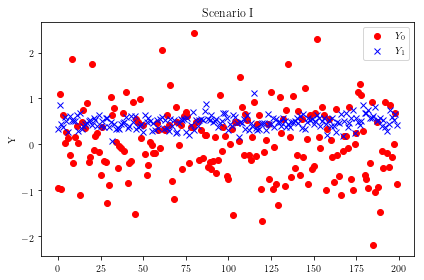

In [5]:
# plot the true functions and the samples
fig, ax = plt.subplots(1,1)

ax.plot(Y0,linewidth=1,linestyle="None",marker='o',color='red',label="Y_0")
ax.plot(Y1,linewidth=1,linestyle="None",marker='x',color='blue',label="Y_1")
ax.legend(["$Y_0$","$Y_1$"])
ax.set_title(r"Scenario I")
ax.set_ylabel(r"Y")
fig.tight_layout()

In [6]:
# save the figure
fig.savefig('cf_data.pdf',dpi=100)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


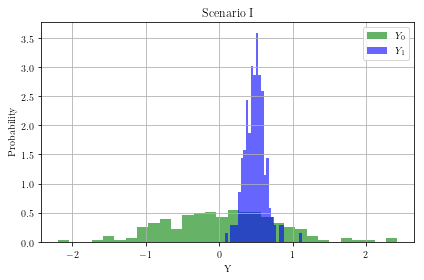

In [7]:
# plot the histograms
fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(Y0,30,normed=1,facecolor='green', alpha=0.6, label="$Y_0$")
y0 = mlab.normpdf(bins, 0, 1)
#l = plt.plot(bins, y0, 'r--', linewidth=2,label='Y0')

n, bins, patches = ax.hist(Y1,30,normed=1,facecolor='blue', alpha=0.6,label="$Y_1$")
y1 = mlab.normpdf(bins, 2, 1)
#l = plt.plot(bins, y1, 'm--', linewidth=2,label='Y1')

ax.legend()
ax.set_title(r"Scenario I")
ax.set_ylabel(r"Probability")
ax.set_xlabel(r"Y")
ax.grid(True)

fig.tight_layout();

In [8]:
# save the figure
fig.savefig('cf_data_hist.pdf',dpi=100)

## Construct Counterfactual Mean Embedding

In [9]:
# kernel function
def gauss_rbf(X1,X2,sigma=1):
    """
    The Gaussian RBF kernel function.
    X1 : the first nxd input data matrix. Each row corresponds to data point
    X2 : the second mxd input data matrix. Each row corresponds to the data point
    """
    
    K = np.exp(-np.divide(cdist(X1,X2,'sqeuclidean'),2*sigma))
    
    return K
###

In [10]:
# Now, given the generated data, construct the estimate of the counterfactual distributions

reg_param = 1e-5

sg = np.median(pairwise_distances(X0, X1, metric='euclidean'))**2

K1 = gauss_rbf(X1,X1,sg)
K2 = gauss_rbf(X1,X0,sg)

# beta vector
b = np.dot(np.dot(np.linalg.inv(K1 + ns*reg_param*np.eye(ns)),K2),np.ones((ns,1))/ns)

## Fit Counterfactual Distribution

In [11]:
Yt = np.linspace(-2,2,200)
Yt = Yt[:,np.newaxis]
YY0 = Y0[:,np.newaxis] # Y

sg = np.median(pairwise_distances(YY0,Yt,metric='euclidean'))**2

In [12]:
def obj_fun(x):
    """ x[0]: mean of the Gaussian, x[1]: variance of the Gaussian """
    
    gm = 1.0/sg
    Yd = (YY0 - x[0])**2
    
    first_term  = np.dot(np.dot(b.T,gauss_rbf(YY0,YY0,sg)),b)
    second_term = np.dot(b.T,np.exp(-0.5*(x[1]**2 + sg)*Yd)/np.sqrt(abs(gm*(x[1]**2) + 1)))
    third_term  = 1.0/np.sqrt(2*(x[1]**2) + 1)
    
    return first_term - 2*second_term + third_term


In [13]:
x0 = [0.0,0.01]
res = minimize(obj_fun, x0, method='BFGS', options={'gtol': 1e-6, 'disp': True})
mm = res.x[0]
ss = res.x[1]
print(mm,ss,res.success)

Optimization terminated successfully.
         Current function value: 0.482297
         Iterations: 10
         Function evaluations: 72
         Gradient evaluations: 18
0.46804674261336443 0.3945774699820924 True


## Plot Counterfactual Distribution

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: 

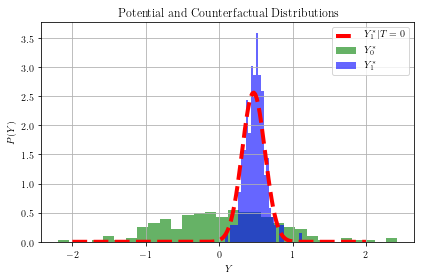

In [14]:
# plot the histograms
fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(Y0,30,normed=1,facecolor='green', alpha=0.6, label="$Y^*_0$")
y0 = mlab.normpdf(bins, 0, 1)

n, bins, patches = ax.hist(Y1,30,normed=1,facecolor='blue', alpha=0.6, label="$Y^*_1$")
y1 = mlab.normpdf(bins, 2, 1)
ax.plot(Yt, norm.pdf(Yt,loc=mm,scale=ss**2),'r--',linewidth=4,label="$Y^*_1|T=0$");

ax.legend()
ax.set_title("Potential and Counterfactual Distributions")
ax.set_xlabel("$Y$")
ax.set_ylabel("$P(Y)$")
ax.grid(True)

fig.tight_layout();

In [15]:
# save the figure
fig.savefig('cf_distributions.pdf', dpi=100)

In [ ]:
# Kernel herding (Algorithm 1)